In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("D:\\Switch\\Projects\\Uplift Modeling\\outputs\\test_predictions.csv")

In [3]:
COST = 0.5
PROFIT = 100
fractions = np.linspace(0.01, 1.0, 50)

In [4]:
#Profit Function
def compute_profit(df, score_col, cost=5, profit=40):
    
    df = df.sort_values(score_col, ascending=False).reset_index(drop=True)
    
    n = len(df)
    profits = []
    
    for frac in np.linspace(0.01, 1.0, 50):
        
        k = int(frac * n)
        targeted = df.iloc[:k]
        
        treated = targeted[targeted['treatment'] == 1]
        control = targeted[targeted['treatment'] == 0]
        
        conv_treated = treated['conversion'].sum()
        conv_control = control['conversion'].sum()
        
        # Incremental conversions
        if len(control) > 0:
            control_rate = conv_control / len(control) #-> Rate of users getting converted without promo
        else:
            control_rate = 0
        
        #control_rate*len(treated) is just expected baseline conversion
        incremental = conv_treated - control_rate * len(treated)
        
        total_profit = incremental * profit - k * cost
        
        profits.append(total_profit)
    
    return profits

In [5]:
random_profits = compute_profit(df, 'score_random', COST, PROFIT)
conversion_profits = compute_profit(df, 'score_conversion', COST, PROFIT)
t_profits = compute_profit(df, 'score_t_learner', COST, PROFIT)
x_profits = compute_profit(df, 'score_x_learner', COST, PROFIT)

In [6]:
results = {
    "Random": max(random_profits),
    "Conversion": max(conversion_profits),
    "T-Learner": max(t_profits),
    "X-Learner": max(x_profits)
}

results

{'Random': np.float64(-2061.5214994487324),
 'Conversion': np.float64(19433.08916323731),
 'T-Learner': np.float64(29344.973268180504),
 'X-Learner': np.float64(41213.048835888694)}

In [8]:
#% improvement of X-Learner over Conversion.
improvement = (
    results["X-Learner"] - results["Conversion"]
) / results["Conversion"] * 100

improvement

np.float64(112.07667236897048)

In [9]:
#Optimal targeting fraction for X-Learner
best_idx = np.argmax(x_profits)
best_fraction = fractions[best_idx]
best_profit = x_profits[best_idx]

best_fraction, best_profit

(np.float64(0.030204081632653063), np.float64(41213.048835888694))

This shows that the most optimal targets would be top 3% highest uplift users.

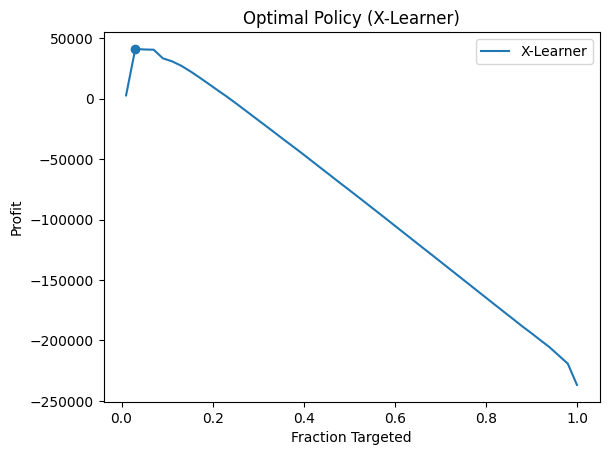

In [10]:
plt.figure()
plt.plot(fractions, x_profits, label="X-Learner")
plt.scatter(best_fraction, best_profit)
plt.xlabel("Fraction Targeted")
plt.ylabel("Profit")
plt.title("Optimal Policy (X-Learner)")
plt.legend()
plt.show()

Building Qini Curve.

In [11]:
def compute_qini(df, score_col):
    
    df = df.sort_values(score_col, ascending=False).reset_index(drop=True)
    
    treated = df['treatment'] == 1
    control = df['treatment'] == 0
    
    cum_treated = (df['conversion'] * treated).cumsum()
    cum_control = (df['conversion'] * control).cumsum()
    
    cum_treated_count = treated.cumsum()
    cum_control_count = control.cumsum()
    
    # Avoid division by zero
    control_rate = np.where(
        cum_control_count > 0,
        cum_control / cum_control_count,
        0
    )
    
    incremental = cum_treated - control_rate * cum_treated_count
    
    return incremental

In [12]:
qini_random = compute_qini(df, 'score_random')
qini_conversion = compute_qini(df, 'score_conversion')
qini_t = compute_qini(df, 'score_t_learner')
qini_x = compute_qini(df, 'score_x_learner')

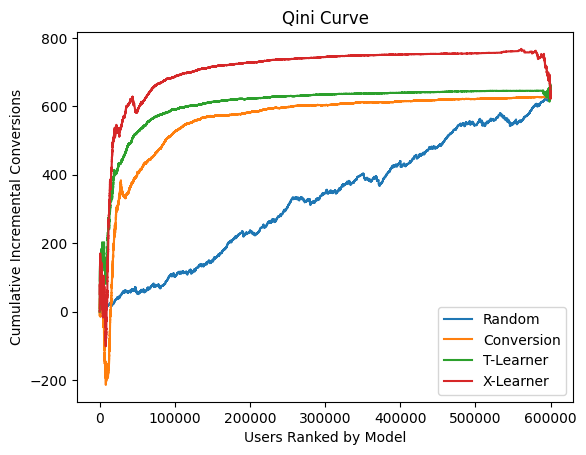

In [13]:
plt.figure()
plt.plot(qini_random, label="Random")
plt.plot(qini_conversion, label="Conversion")
plt.plot(qini_t, label="T-Learner")
plt.plot(qini_x, label="X-Learner")

plt.xlabel("Users Ranked by Model")
plt.ylabel("Cumulative Incremental Conversions")
plt.title("Qini Curve")
plt.legend()
plt.show()

X learner has the highest curve throughout.

In [17]:
#Qini AUC
from numpy import trapezoid

qini_auc = {
    "Random": trapezoid(qini_random),
    "Conversion": trapezoid(qini_conversion),
    "T-Learner": trapezoid(qini_t),
    "X-Learner": trapezoid(qini_x)
}

qini_auc

{'Random': np.float64(196257467.49271184),
 'Conversion': np.float64(334875271.6896385),
 'T-Learner': np.float64(363180865.93616587),
 'X-Learner': np.float64(424267456.9948151)}

X-Learner has the highest uplift ranking quality.

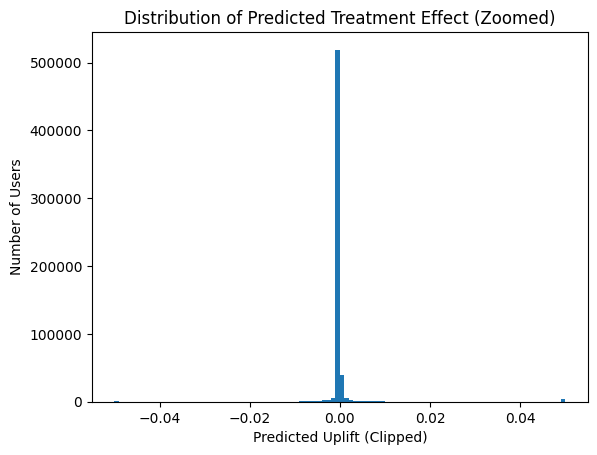

In [ ]:
#Uplift Distribution Plot
plt.figure()
clipped = df['score_x_learner'].clip(-0.05, 0.05)

plt.hist(clipped, bins=100)
plt.xlabel("Predicted Uplift (Clipped)")
plt.ylabel("Number of Users")
plt.title("Distribution of Predicted Treatment Effect (Zoomed)")
plt.show()

In [20]:
#Sensitivity Analysis
cost_values = [0.25, 0.5, 1, 2]
profit_values = [50, 75, 100, 150]

In [21]:
sensitivity_results = []

for cost in cost_values:
    for profit in profit_values:
        
        profits = compute_profit(df, 'score_x_learner', cost, profit)
        max_profit = max(profits)
        
        sensitivity_results.append({
            "Cost": cost,
            "Profit_per_Conversion": profit,
            "Max_Profit": max_profit
        })

sens_df = pd.DataFrame(sensitivity_results)
sens_df

,Cost,Profit_per_Conversion,Max_Profit
0,0.25,50,20606.524418
1,0.25,75,35704.453649
2,0.25,100,51136.521532
3,0.25,150,82000.657298
4,0.50,50,16076.024418
5,0.50,75,28644.536627
6,0.50,100,41213.048836
7,0.50,150,71408.907298
8,1.00,50,7015.024418
9,1.00,75,19583.536627


Uplift-based targeting remains profitable across a wide range of promotion costs and margins, but campaign viability deteriorates under high-cost, low-margin scenarios.